## Stroke prediction dataset - Unsupervised learning

Stroke is the 2nd leading cause of death globally, responsible for around 11% of total deaths accorrding to the World Health Organisation (WHO)

# Features in this dataset:

1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension (high blood pressure)
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood (high blood sugar levels increases risk of stroke)
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

- Dataset is from kaggle and the original source is noted as confidential.

- 5110 records and 12 columns


# Question

Is the patient likely to get a stroke? 

Can we get the labels for stoke and no stroke classes?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions_stroke as f

from fast_ml.model_development import train_valid_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2 as score_func
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV


In [2]:
stroke = pd.read_csv("data/stroke_data.csv")

stroke.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
stroke.shape

(5110, 12)

In [4]:
# Count of stoke vs no stroke in the dataset

stroke_count = pd.DataFrame(stroke['stroke'].value_counts()).rename({'stroke':'Count'}, axis=1)
stroke_percent = ((pd.DataFrame(stroke['stroke'].value_counts())/len(stroke))*100).round(2).rename({'stroke':'%'}, axis=1)

stroke_counts = pd.concat([stroke_count, stroke_percent], axis=1)
stroke_counts

# ref 8

,Count,%
0,4861,95.13
1,249,4.87


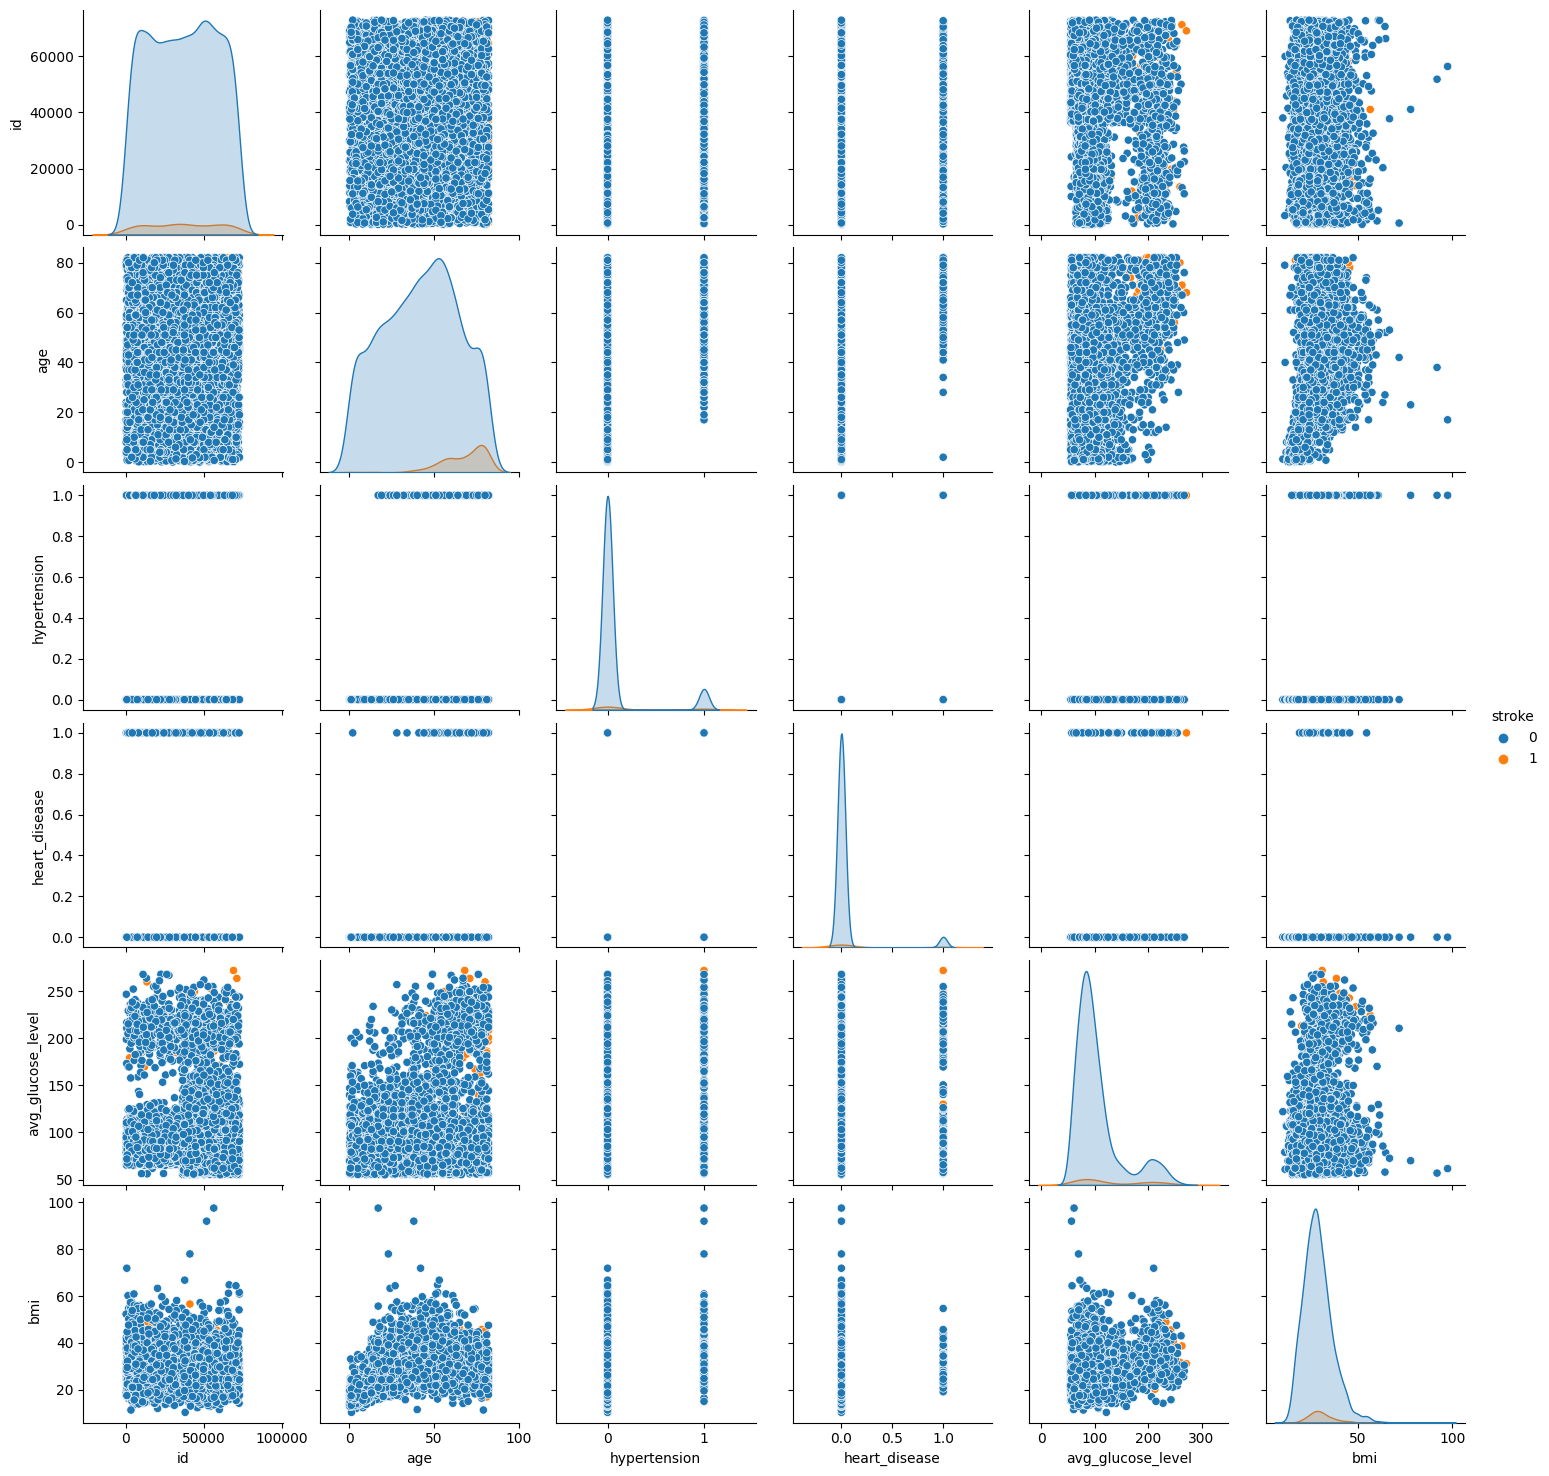

In [5]:
# Look at the real stroke labels.
sns.pairplot(data=stroke, hue='stroke')

# Remove label column for unsupervised learning

In [6]:
# remove label column
stroke_unlabelled = stroke.drop(['stroke'], axis = 1)

In [7]:
# store target variable with id column so can be joined back with feature data later
stroke_target = stroke[['id', 'stroke']]

In [8]:
stroke_target.head()

,id,stroke
0,9046,1
1,51676,1
2,31112,1
3,60182,1
4,1665,1


In [9]:
stroke_unlabelled.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


# EDA, clean dataset, encode non-numeric variables

In [10]:
stroke_unlabelled.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
dtype: object

In [11]:
# find proportion of 0 values in each column
missing_percentage = (stroke_unlabelled==0).sum()*100/stroke_unlabelled.shape[0]
print(f"Proportion of missing values: \n\n{missing_percentage}")

# no 0 values in dataset that shouldn't be there.

Proportion of missing values: 

id                    0.000000
gender                0.000000
age                   0.000000
hypertension         90.254403
heart_disease        94.598826
ever_married          0.000000
work_type             0.000000
Residence_type        0.000000
avg_glucose_level     0.000000
bmi                   0.000000
smoking_status        0.000000
dtype: float64


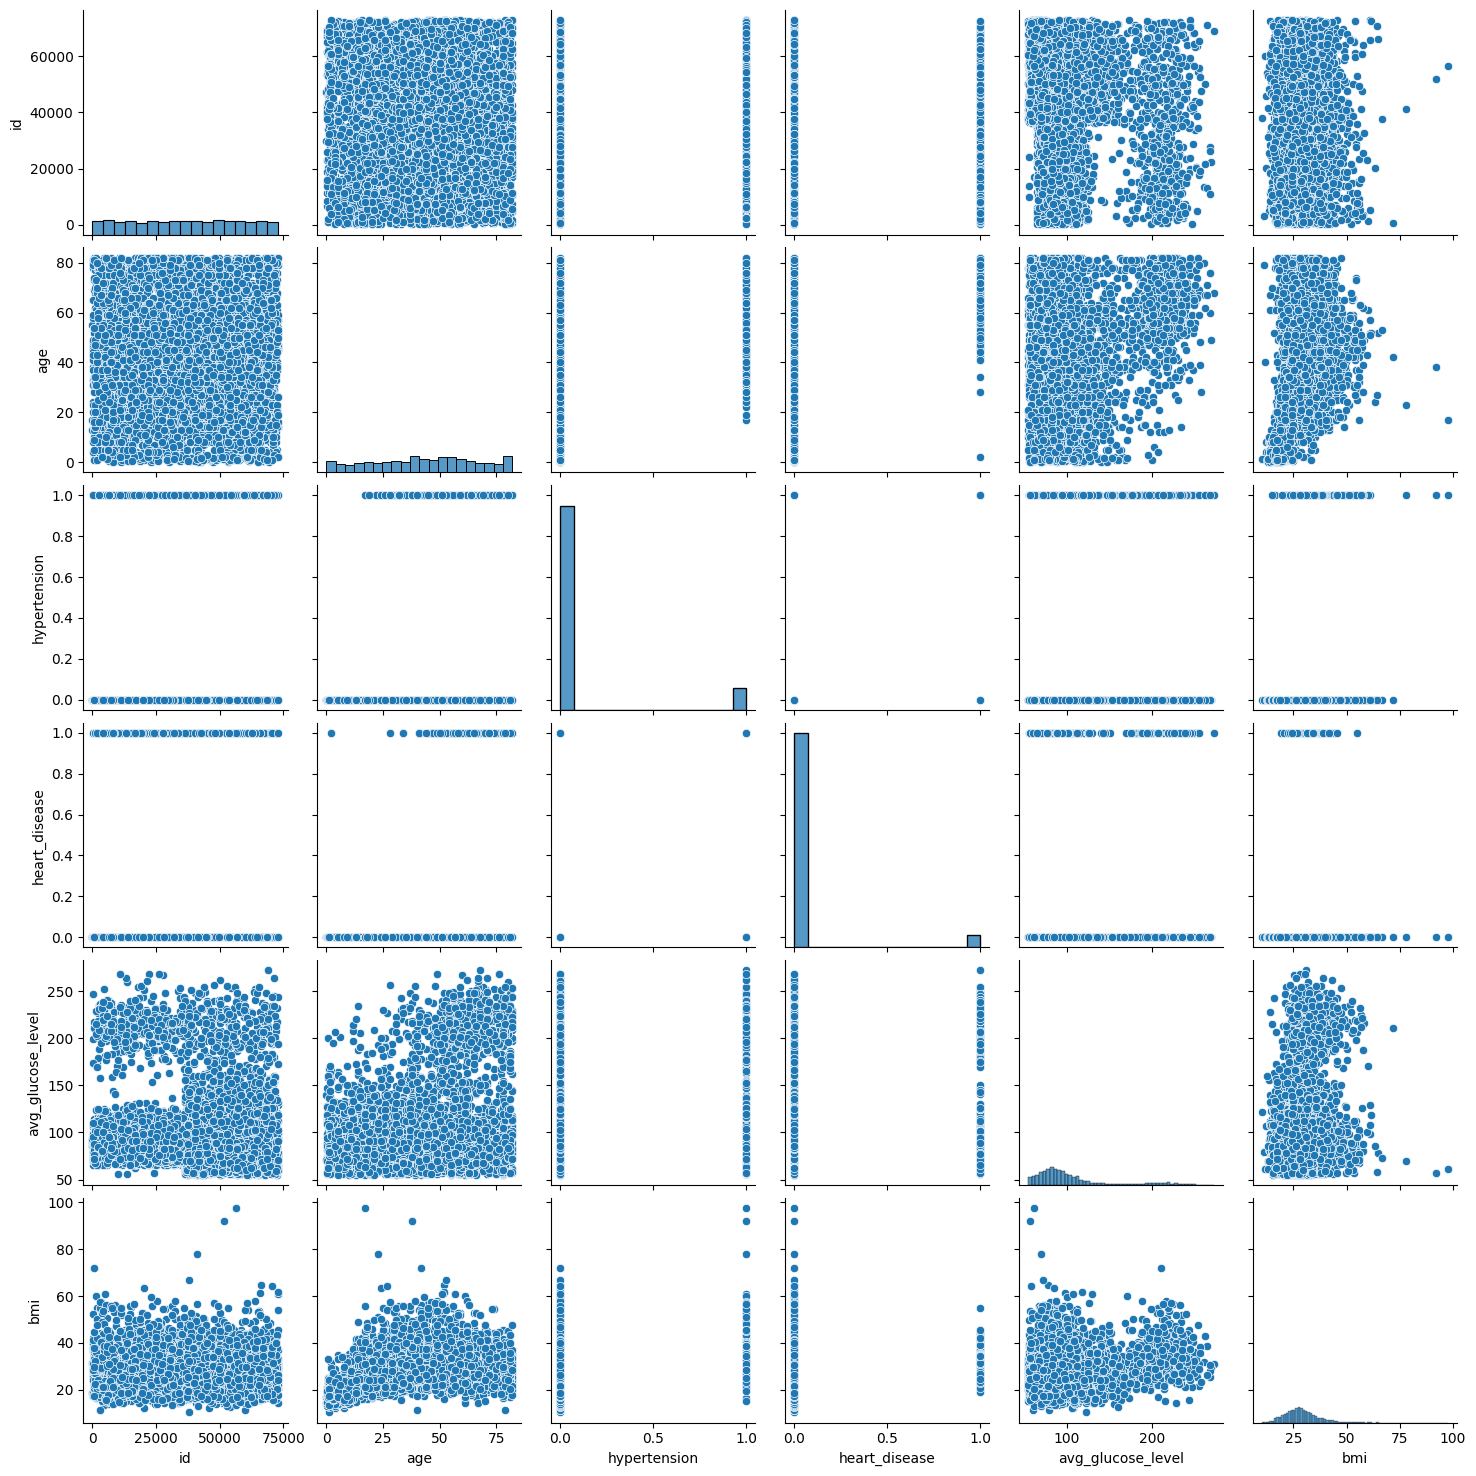

In [12]:
# visualise features in pairs
sns.pairplot(stroke_unlabelled)
plt.show()

In [14]:
# Value counts and catefories of non numeric columns
# gender = male, female
# married = yes or no
# work type
# residence type
# smoking status

print(f"Gender: \n {stroke_unlabelled['gender'].value_counts()} \n\n")
print(f" Ever married: \n {stroke_unlabelled['ever_married'].value_counts()} \n\n")
print(f"Work type: \n {stroke_unlabelled['work_type'].value_counts()} \n\n")
print(f"Residence type: \n {stroke_unlabelled['Residence_type'].value_counts()} \n\n")
print(f"Smoking staturs: \n {stroke_unlabelled['smoking_status'].value_counts()} \n\n")


Gender: 
 Female    2994
Male      2115
Other        1
Name: gender, dtype: int64 


 Ever married: 
 Yes    3353
No     1757
Name: ever_married, dtype: int64 


Work type: 
 Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64 


Residence type: 
 Urban    2596
Rural    2514
Name: Residence_type, dtype: int64 


Smoking staturs: 
 never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64 




In [15]:
# remove single record of gender which is 'other' as doesn't provide much information with just the one record
stroke_unlabelled = stroke_unlabelled[~stroke_unlabelled['gender'].isin(['Other'])]

In [16]:
stroke_unlabelled['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [17]:
# gender, residence type and ever married - encode manually by mapping as 1s and 0s as have only 2 options per feature

stroke_unlabelled['gender'] = stroke_unlabelled['gender'].map({'Male': 1, 'Female': 0})
stroke_unlabelled['Residence_type'] = stroke_unlabelled['Residence_type'].map({'Urban': 1, 'Rural': 0})
stroke_unlabelled['ever_married'] = stroke_unlabelled['ever_married'].map({'Yes': 1, 'No': 0})

In [ ]:
stroke_unlabelled.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,9046,1,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked
1,51676,0,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked
2,31112,1,80.0,0,1,1,Private,0,105.92,32.5,never smoked
3,60182,0,49.0,0,0,1,Private,1,171.23,34.4,smokes
4,1665,0,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked


In [18]:
# smoking status and work type - using dummy variables as columns have multiple options per feature that don't have any particular order

stroke_unlabelled = pd.get_dummies(stroke_unlabelled, columns = ['smoking_status', 'work_type'])

stroke_unlabelled.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,9046,1,67.0,0,1,1,1,228.69,36.6,0,1,0,0,0,0,1,0,0
1,51676,0,61.0,0,0,1,0,202.21,NaN,0,0,1,0,0,0,0,1,0
2,31112,1,80.0,0,1,1,0,105.92,32.5,0,0,1,0,0,0,1,0,0
3,60182,0,49.0,0,0,1,1,171.23,34.4,0,0,0,1,0,0,1,0,0
4,1665,0,79.0,1,0,1,0,174.12,24.0,0,0,1,0,0,0,0,1,0


In [19]:
stroke_unlabelled.dtypes

id                                  int64
gender                              int64
age                               float64
hypertension                        int64
heart_disease                       int64
ever_married                        int64
Residence_type                      int64
avg_glucose_level                 float64
bmi                               float64
smoking_status_Unknown              uint8
smoking_status_formerly smoked      uint8
smoking_status_never smoked         uint8
smoking_status_smokes               uint8
work_type_Govt_job                  uint8
work_type_Never_worked              uint8
work_type_Private                   uint8
work_type_Self-employed             uint8
work_type_children                  uint8
dtype: object

In [20]:
# any missing values?

stroke_unlabelled.isnull().sum()

# null values in BMI

id                                  0
gender                              0
age                                 0
hypertension                        0
heart_disease                       0
ever_married                        0
Residence_type                      0
avg_glucose_level                   0
bmi                               201
smoking_status_Unknown              0
smoking_status_formerly smoked      0
smoking_status_never smoked         0
smoking_status_smokes               0
work_type_Govt_job                  0
work_type_Never_worked              0
work_type_Private                   0
work_type_Self-employed             0
work_type_children                  0
dtype: int64

In [21]:
# Correlations

stroke_unlabelled.corr()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
id,1.000000,0.001929,0.003677,0.003610,-0.001253,0.013944,-0.001219,0.000943,0.003238,-0.019126,0.007419,0.011567,0.001081,0.000054,0.005471,0.023545,-0.019879,-0.013869
gender,0.001929,1.000000,-0.027752,0.021223,0.085685,-0.030171,-0.006105,0.054722,-0.026164,0.059557,0.043121,-0.098952,0.011408,-0.016598,0.011486,-0.032502,-0.026045,0.089226
age,0.003677,-0.027752,1.000000,0.276367,0.263777,0.679084,0.014031,0.238323,0.333314,-0.378366,0.237347,0.119207,0.073075,0.129965,-0.078667,0.116678,0.327949,-0.634320
hypertension,0.003610,0.021223,0.276367,1.000000,0.108292,0.164187,-0.007980,0.174540,0.167770,-0.141551,0.059022,0.065018,0.031213,0.017661,-0.021612,-0.005358,0.115417,-0.129535
heart_disease,-0.001253,0.085685,0.263777,0.108292,1.000000,0.114601,0.003045,0.161907,0.041322,-0.066765,0.066938,-0.021893,0.044030,0.001312,-0.015715,0.000068,0.086742,-0.091654
ever_married,0.013944,-0.030171,0.679084,0.164187,0.114601,1.000000,0.005988,0.155329,0.341553,-0.332335,0.171960,0.102663,0.105132,0.133964,-0.090873,0.154104,0.192637,-0.544658
Residence_type,-0.001219,-0.006105,0.014031,-0.007980,0.003045,0.005988,1.000000,-0.004783,-0.000293,-0.002167,0.008093,-0.024622,0.027185,0.013056,0.022848,-0.018005,0.010508,-0.002388
avg_glucose_level,0.000943,0.054722,0.238323,0.174540,0.161907,0.155329,-0.004783,1.000000,0.175672,-0.095035,0.067796,0.024011,0.017716,0.013908,-0.014665,0.016451,0.062770,-0.102195
bmi,0.003238,-0.026164,0.333314,0.167770,0.041322,0.341553,-0.000293,0.175672,1.000000,-0.270481,0.107463,0.107847,0.088261,0.079526,-0.028615,0.208205,0.072634,-0.448779
smoking_status_Unknown,-0.019126,0.059557,-0.378366,-0.141551,-0.066765,-0.332335,-0.002167,-0.095035,-0.270481,1.000000,-0.301028,-0.504695,-0.281249,-0.097473,0.008796,-0.209926,-0.106313,0.512721


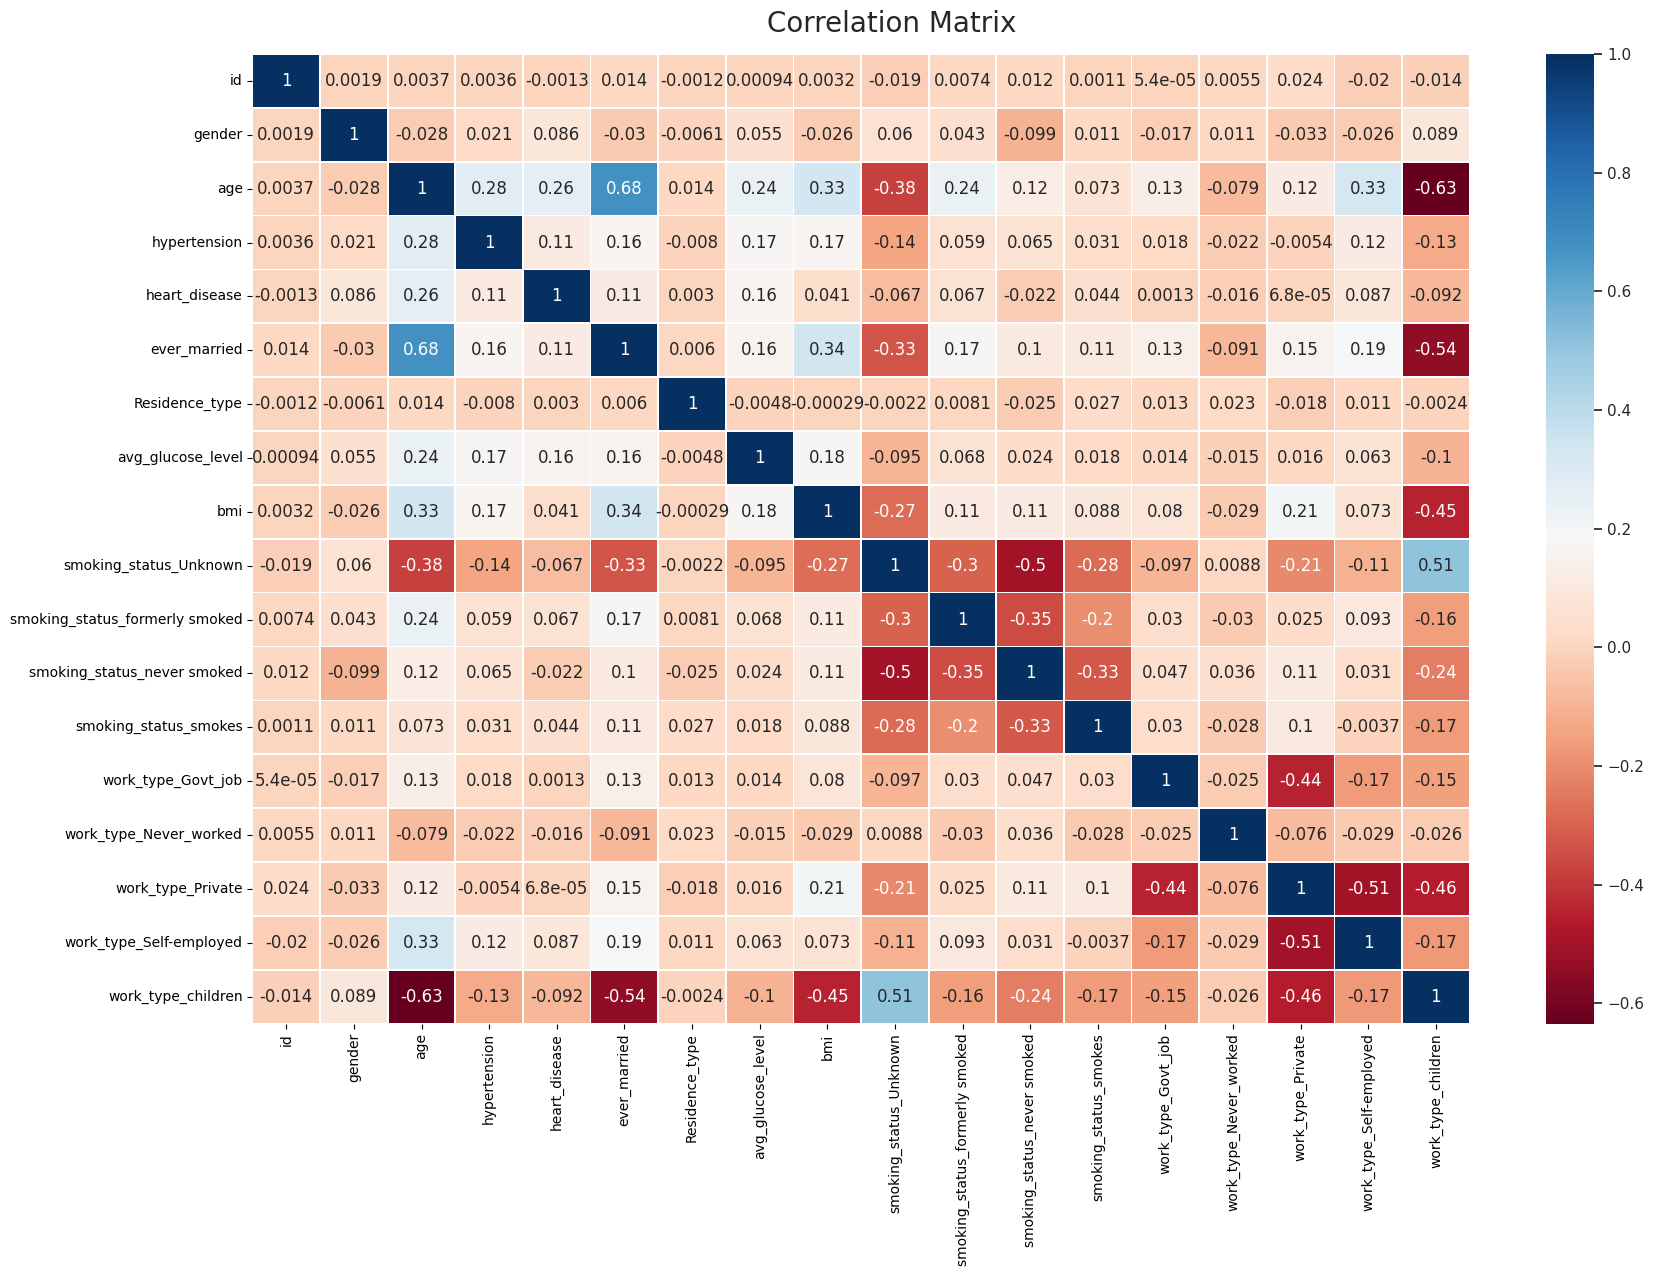

In [22]:
# Heatmap
colormap = plt.cm.RdBu

plt.subplots(figsize = (18,13))
sns.set(font_scale = 1)

hmap = sns.heatmap(data = stroke_unlabelled.corr(numeric_only = True),
            annot = True,
            linewidths = .5,
            cmap = colormap
            )

plt.suptitle("Correlation Matrix", fontsize = 20)
plt.tight_layout()

Correlations seen:

Moderate negative correlations seen between:

    - Age and work_type_children = -0.63 (suggests as you get older you are less likely to work in a role with children, logical as working with children is physically demanding and tiring.)

    - ever_married and work_type_children = -0.54 (suggests similar to above as being married is more likely as you get older)

Moderate positive correlation between:

    - Age and ever_married = 0.68 (makes sense as the older you are the more likely it is you have been married at some point)

In [ ]:
## Check data

# About stroke dataset
print('Stroke dataset is a %s' % type(stroke_unlabelled))
print('Stroke dataset has %d rows and %d columns' % stroke_unlabelled.shape)
print('Basic Statistics about stroke dataset%s' % ('_'*50))
print(stroke_unlabelled.describe())

Stroke dataset is a <class 'pandas.core.frame.DataFrame'>
Stroke dataset has 5109 rows and 18 columns
Basic Statistics about stroke dataset__________________________________________________
                 id       gender          age  hypertension  heart_disease  \
count   5109.000000  5109.000000  5109.000000   5109.000000    5109.000000   
mean   36513.985516     0.413975    43.229986      0.097475       0.054022   
std    21162.008804     0.492592    22.613575      0.296633       0.226084   
min       67.000000     0.000000     0.080000      0.000000       0.000000   
25%    17740.000000     0.000000    25.000000      0.000000       0.000000   
50%    36922.000000     0.000000    45.000000      0.000000       0.000000   
75%    54643.000000     1.000000    61.000000      0.000000       0.000000   
max    72940.000000     1.000000    82.000000      1.000000       1.000000   

       ever_married  Residence_type  avg_glucose_level         bmi  \
count   5109.000000     5109.000000  

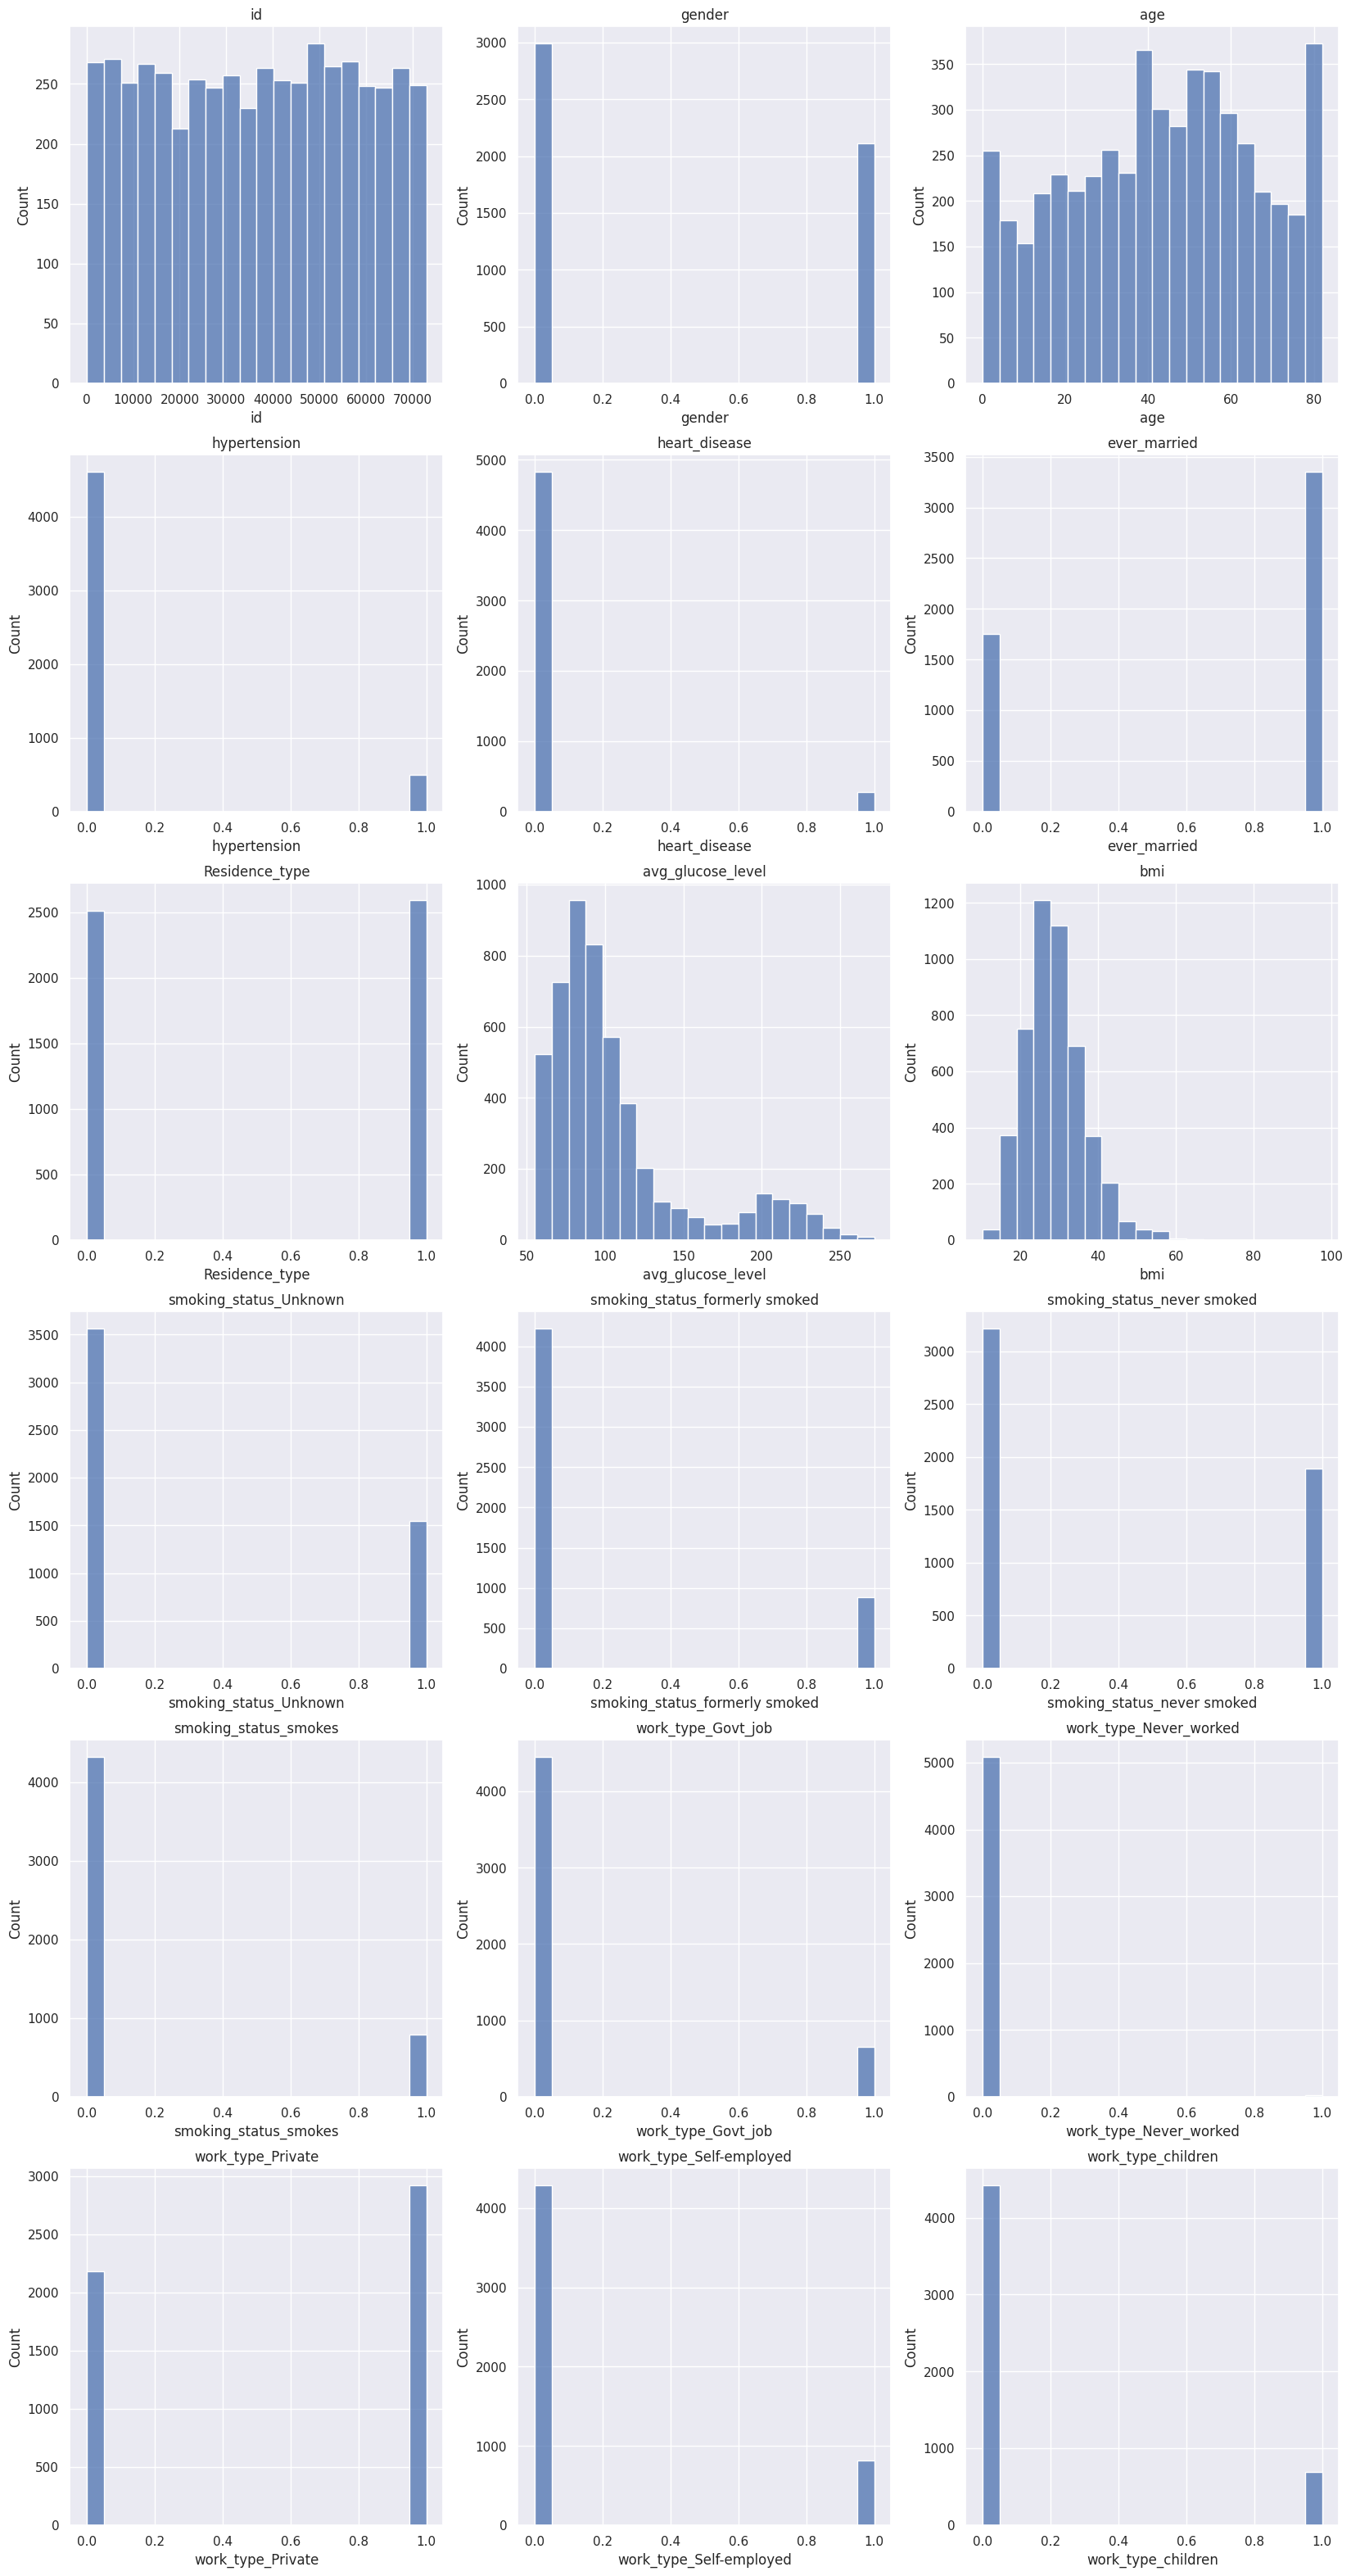

In [ ]:
# sns distribution plots of numeric features after encoding
N_col = list(stroke_unlabelled.columns)

plt.figure(figsize=(20,60), facecolor='white')
plotnum=1
for col in N_col:
    ax=plt.subplot(9,3,plotnum)
    sns.histplot(stroke_unlabelled[col], bins=20)
    plt.title(col)
    plotnum+=1
plt.show()

In [23]:
# Impute NaNs in BMI column (201/5110 = 0.039 or 3.9% of the values in the column)

stroke_unlabelled_imputed = stroke_unlabelled.apply(lambda x: x.fillna(x.median()),axis=0)

rslt = stroke_unlabelled_imputed.isnull().sum()

print(f'After median values applied: \n {rslt}')

After median values applied: 
 id                                0
gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
dtype: int64


# Split data into train, validate and test sets

In [24]:
# Using a 60%, 20%, 20% split for training, validation and test sets
# don't touch test set until the end.

stroke_unlabelled_imputed = pd.merge(stroke_unlabelled_imputed, stroke_target, on = "id", how = 'left')

x_feats = stroke_unlabelled_imputed.drop('stroke', axis = 1, inplace = False)

y_labs = stroke_unlabelled_imputed['stroke']

x, X_test, y, y_test = train_test_split(x_feats, y_labs, test_size=0.2, train_size=0.8, random_state = 1)
X_train, X_validate, y_train, y_validate = train_test_split(x, y, test_size = 0.25, train_size =0.75, random_state = 1)


# ref 2

In [25]:
print(X_train.shape, X_validate.shape, X_test.shape)

print(y_train.shape, y_validate.shape, y_test.shape)

(3065, 18) (1022, 18) (1022, 18)
(3065,) (1022,) (1022,)


In [ ]:
X_train.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
2986,33562,1,71.0,0,1,1,0,72.94,32.3,0,1,0,0,1,0,0,0,0
2704,11727,1,39.0,0,0,1,1,74.29,29.3,0,0,0,1,0,0,0,1,0
4799,40850,0,74.0,0,0,1,1,111.94,21.7,0,0,1,0,1,0,0,0,0
4239,26935,0,50.0,1,0,1,1,213.43,36.7,0,0,0,1,0,0,1,0,0
655,41927,0,28.0,0,0,1,0,64.64,22.1,0,0,1,0,0,0,1,0,0


In [ ]:
y_train.head()

2986    0
2704    0
4799    0
4239    0
655     0
Name: stroke, dtype: int64

# Use elbow method to optimise hyper-parameter k

Using the elbow method we can see that between 2-4 classes looks to be optimum. However, as the question is whether or not a person has a stroke, we can logically assume that we expect to see 2 classes (stoke and no stroke). Therefore will use k = 2.

In [ ]:
# Use elbow method to find optimal k

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_train)
    distortions.append(kmeanModel.inertia_)

# ref 3

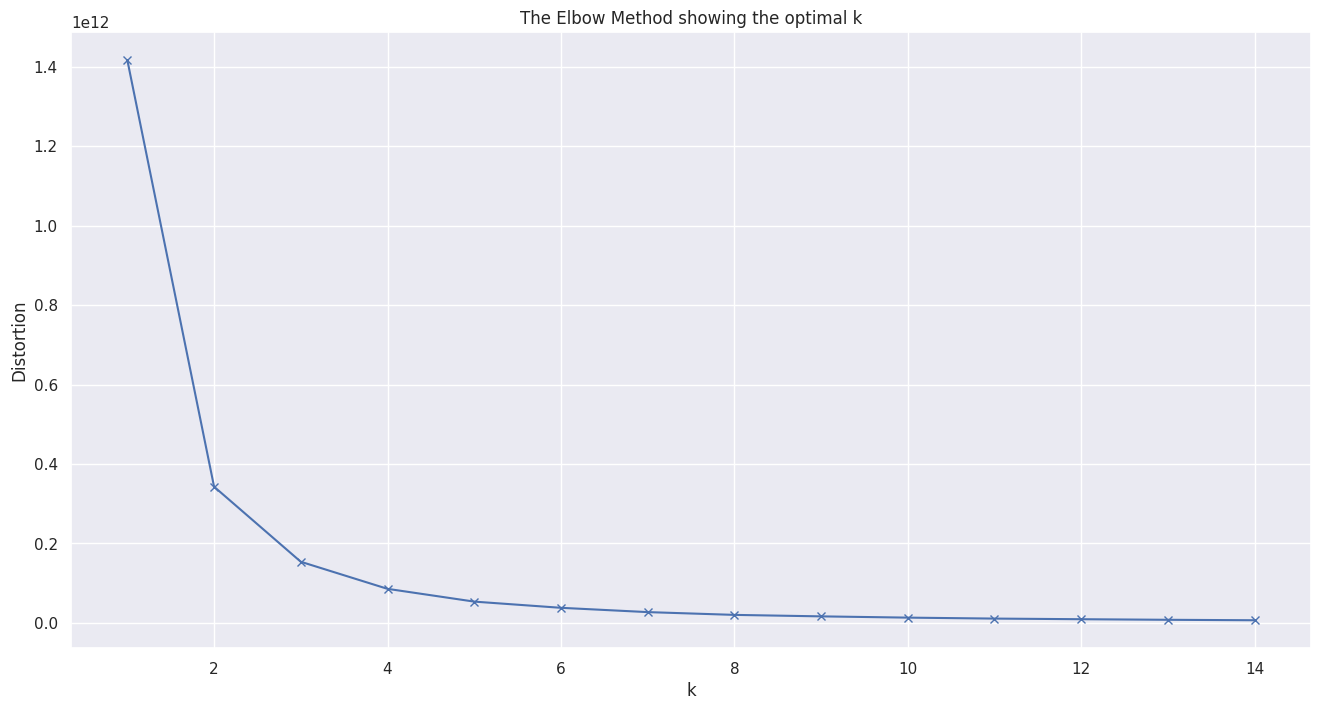

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Use unsupervised learning to cluster the data

# K-means method

Definition:

A method of grouping data points which uses the concept of assigning points to the nearest cluster based on their proximity to the central average points (centroids).

How it works:

1) Choose the number of clusters (k)
2) Select k cluster centres (randomly or using farthest point)
3) Calculate the distance of each point to the cluster centres (centroids)
4) Assign points to their nearest cluster
5) Recalculate new cluster centres (the average of all the points that were assigned to that cluster)
6) Repeat 3) - 5) until cluster centres stop moving (or a stop criterion is reached)

Assumptions:
- The number of clusters is correct (k)
- The data has a circular distribution
- The cluster sizes are approximately the same
- Variance of each variable is the same

Pros:
- Fast, robust and easy to understand
- Quite efficient
- Works well for datasets with distinctly separated groups

Cons:
- Requires setting the number of clusters (k), if the selected k is different from actual k then the results will be very different.
- Exclusive assignment (can't split overlapping data).
- Different non linear transformations of the data will yield different results.

Ref 4


labels: 

 [0 0 0 ... 0 0 0] 


Inertia score for k_means model: 

 47035.14743173065 


Accuracy score for k_means model: 

 0.7856443719412725 


Centroids 

 [[ 1.74125104e-02 -4.05537394e-02  3.03510267e-01  6.53522411e-02
   4.79553788e-02  2.84474808e-01  1.88290761e-03  5.54172382e-02
   2.05529308e-01 -2.61099818e-01  8.54983014e-02  1.18166466e-01
   8.40896369e-02  7.11250538e-02 -7.01286873e-02  1.79730875e-01
   7.62910180e-02 -3.96283223e-01]
 [-8.74388540e-02  2.03645104e-01 -1.52411050e+00 -3.28173533e-01
  -2.40813258e-01 -1.42852182e+00 -9.45522955e-03 -2.78283813e-01
  -1.03208824e+00  1.31114172e+00 -4.29339211e-01 -5.93386026e-01
  -4.22265446e-01 -3.57162353e-01  3.52158988e-01 -9.02538541e-01
  -3.83103815e-01  1.98998019e+00]] 




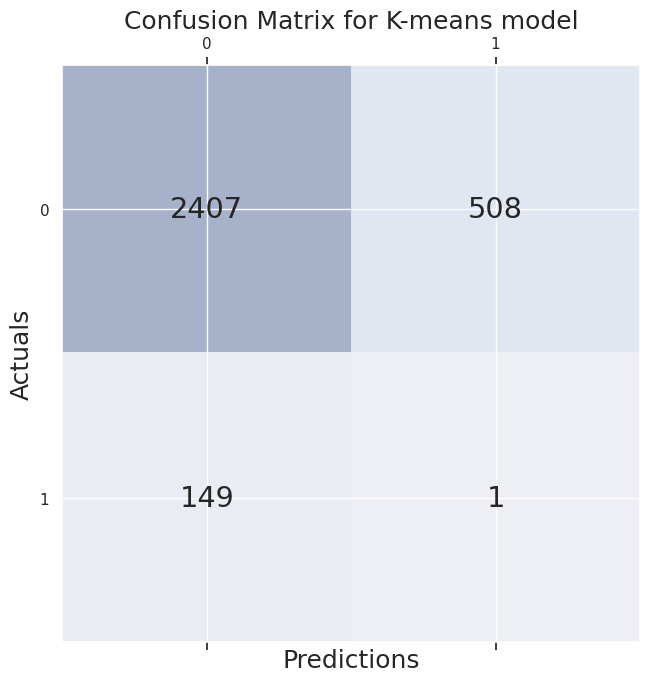

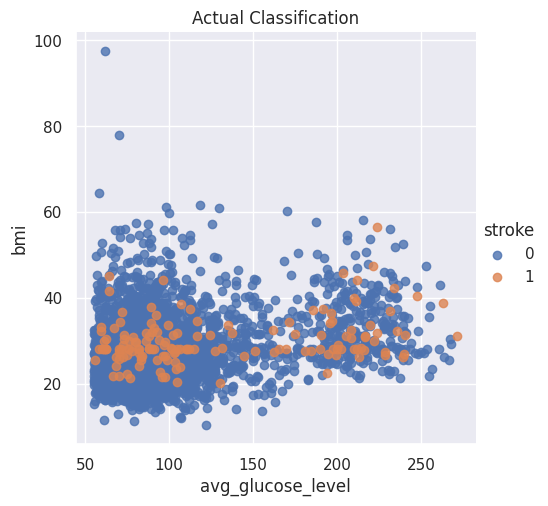

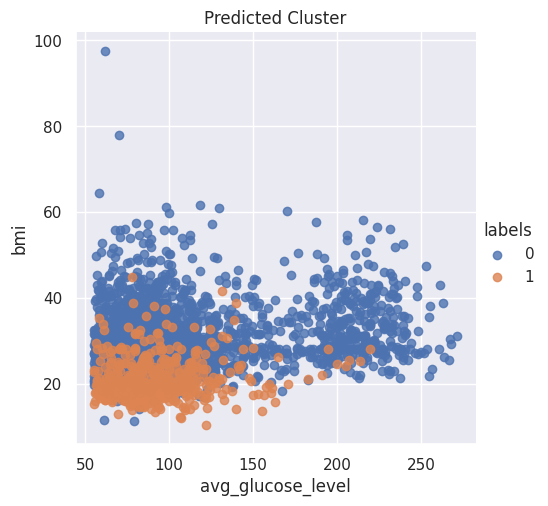

TASK 3: 
 Adjusted rand score for k_means: 

           -0.05755492109620379 


Decision tree labels: 

 [0 0 0 ... 0 0 0] 


adjusted rand score for decision tree: 

 0.011960075393522016 


predict proba: 

 [[0.85678392 0.14321608]
 [0.99517782 0.00482218]
 [0.85678392 0.14321608]
 ...
 [0.99517782 0.00482218]
 [0.94097996 0.05902004]
 [0.94097996 0.05902004]] 




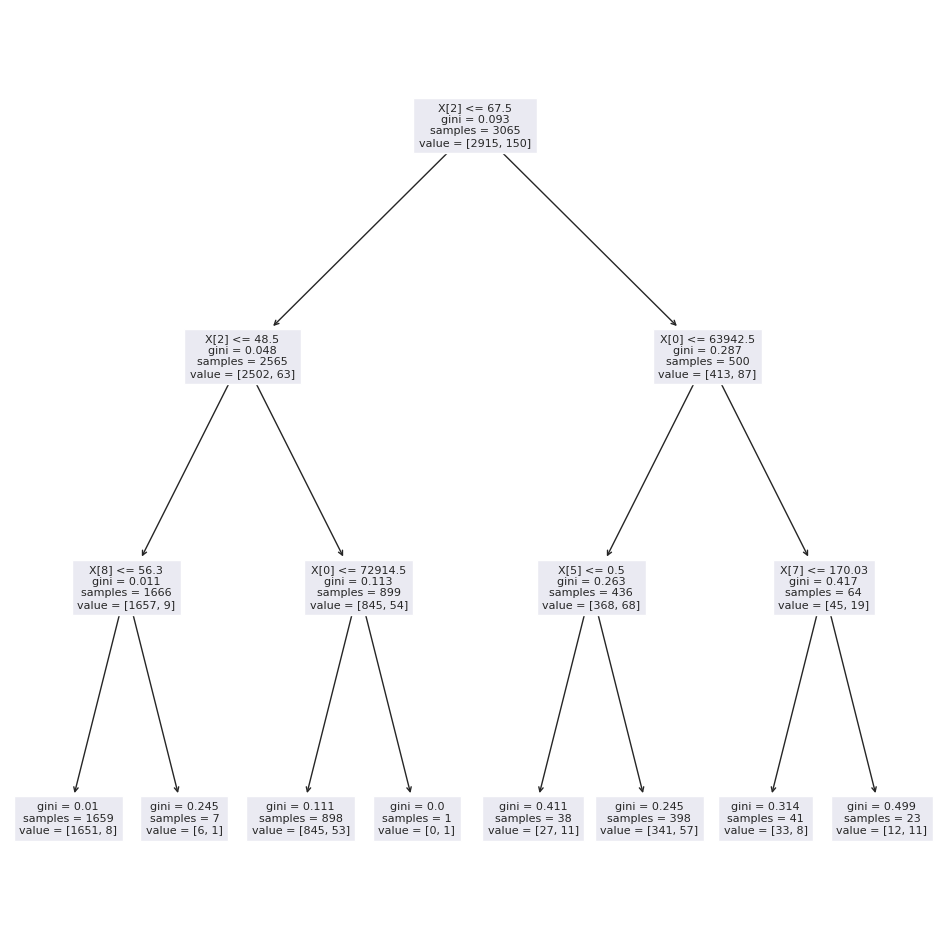

Accuracy score for decision tree model: 

 0.9513866231647634 




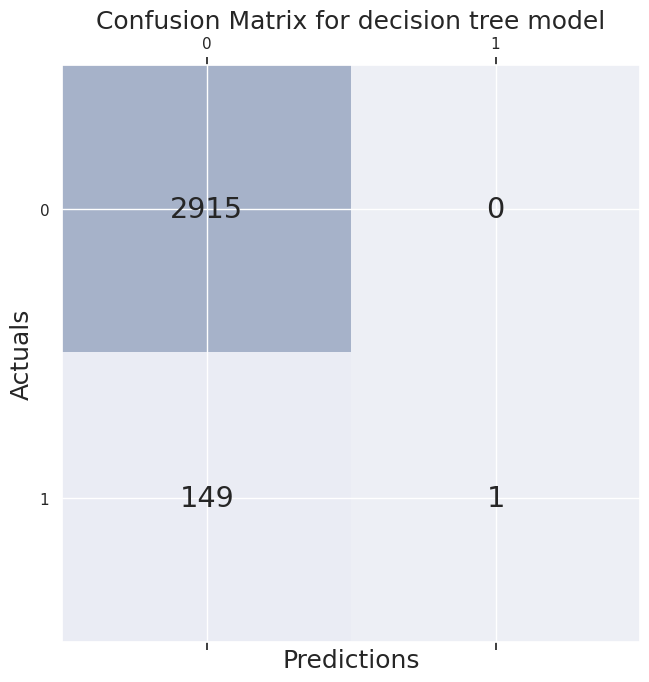

In [26]:
# Run KMeans model using all features

f.run_kmeans(X_train, y_train)

The model is performing fairly well in terms of accuracy score. 

However, the adj rand score is -ve which indicates that the labels created by k-means are a worse choice than if selected at random.
Also, the confusion matrix shows that most of the stroke cases have been missclassified. This would not make for a good model in a medical setting.
(ref 12)

- This could be due to the cluster sizes being very different with 5% stroke patients and 95% non-stroke patients in the dataset. This breaks one of the assumptions of K-Means (where cluster sizes should be similar). Also, the clusters are not clearly separated.

However, using a decision tree appears to have resulted in much higher accuracy. However, looking at the confusion matrix, we can see that while it has done a better job classifying the non-stroke cases, it hasn't performed any better on the stroke cases classification. With most of these cases still miss-classified. In this instance, this would not provide a useful model.

What to do?
 - This dataset would work well with random forest or gradient boosting models, such as XGboost.
 - Use a random subset of the non-stroke patients so that clusters are similar in size and run K-Means model again. However, would be a very small dataset (~250 samples per cluster)

# Using balanced data

In [27]:
# run kmeans with balanced groups by choosing random sample of 250 rows of people who don't have stroke.
# split 1s and 0s for stroke - pick out 250 rows at random with 0s and combine with 1s to make new input df

stroke_cleaned_w_y = stroke_unlabelled_imputed

stroke_unlabelled_imputed_1s = stroke_cleaned_w_y [stroke_cleaned_w_y ['stroke'] == 1]

stroke_unlabelled_imputed_0s = stroke_cleaned_w_y [stroke_cleaned_w_y ['stroke'] == 0]

# reduce 0s dataset to 250 rows
stroke_unlabelled_imputed_0s = stroke_unlabelled_imputed_0s.sample(n = 250)

# combine stroke data and new smaller no stroke data for analysis

balanced_data = pd.concat([stroke_unlabelled_imputed_0s, stroke_unlabelled_imputed_1s])

balanced_data = shuffle(balanced_data)

In [ ]:
balanced_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,stroke
188,30184,1,82.0,0,0,1,0,86.62,29.5,0,1,0,0,0,0,1,0,0,1
2557,42556,1,27.0,0,0,1,1,150.10,25.3,0,0,1,0,0,0,1,0,0,0
606,7446,1,44.0,0,0,1,1,83.51,31.2,0,0,1,0,0,0,1,0,0,0
2672,15018,0,23.0,0,0,0,1,84.46,28.4,0,1,0,0,1,0,0,0,0,0
27,61843,1,58.0,0,0,1,0,189.84,28.1,1,0,0,0,0,0,1,0,0,1


In [28]:
# Create train, validate and test sets

x_feats1 = balanced_data.drop('stroke', axis = 1, inplace = False)

y_labs1 = balanced_data['stroke']

x1, X_test1, y1, y_test1 = train_test_split(x_feats1, y_labs1, test_size=0.2, train_size=0.8, random_state = 1)
X_train1, X_validate1, y_train1, y_validate1 = train_test_split(x1, y1, test_size = 0.25, train_size =0.75, random_state = 1)

In [ ]:
X_train1.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
205,51314,0,78.0,0,0,1,1,106.74,33.0,0,1,0,0,0,0,1,0,0
1291,43124,0,50.0,0,0,1,1,74.72,28.5,0,0,1,0,1,0,0,0,0
1215,61983,0,41.0,0,0,1,1,133.76,43.4,0,0,0,1,0,0,1,0,0
3748,70230,0,14.0,0,0,0,0,77.52,21.9,0,0,1,0,0,0,0,1,0
1233,39823,0,41.0,0,0,1,0,229.86,35.2,0,0,0,1,1,0,0,0,0


In [ ]:
print(stroke_unlabelled_imputed_0s.shape, stroke_unlabelled_imputed_1s.shape, balanced_data.shape)

(250, 19) (249, 19) (499, 19)


labels: 

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0] 


Inertia score for k_means model: 

 4643.096480644523 


Accuracy score for k_means model: 

 0.4214046822742475 


Centroids 

 [[-0.04184649 -0.00644168  0.2280266   0.05212715  0.03847253  0.20379123
   0.02248518  0.06777157  0.12924916 -0.15998971  0.04823462  0.07607908
   0.03485067  0.04579867 -0.05792844  0.09763599  0.05437643 -0.30206105]
 [ 0.38960528  0.05997423 

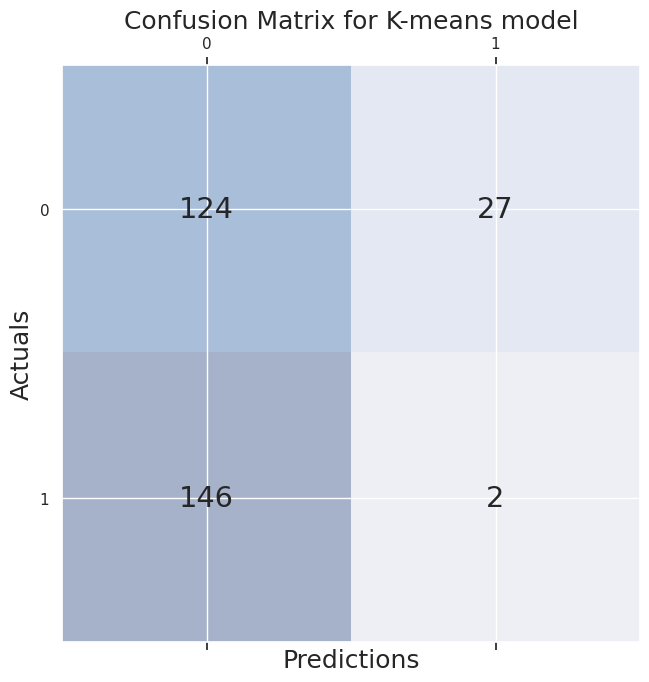

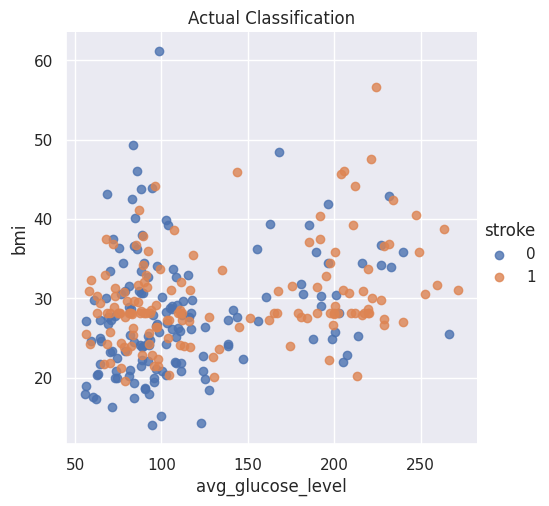

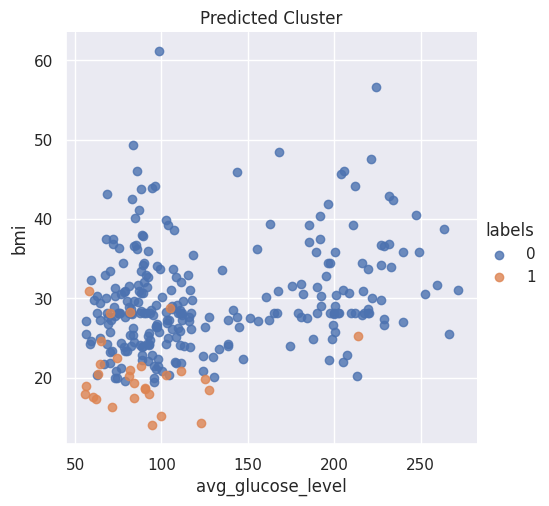

TASK 3: 
 Adjusted rand score for k_means: 

           0.023497159999728828 


Decision tree labels: 

 [1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0
 0 1 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1
 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1
 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0
 1 1 0] 


adjusted rand score for decision tree: 

 0.3172215116556409 


predict proba: 

 [[0.28571429 0.71428571]
 [0.07142857 0.92857143]
 [0.         1.        ]
 [0.28571429 0.71428571]
 [0.07142857 0.92857143]
 [0.5        0.5       ]
 [0.73972603 0.26027397]
 [0.73972603 0.26027397]
 [

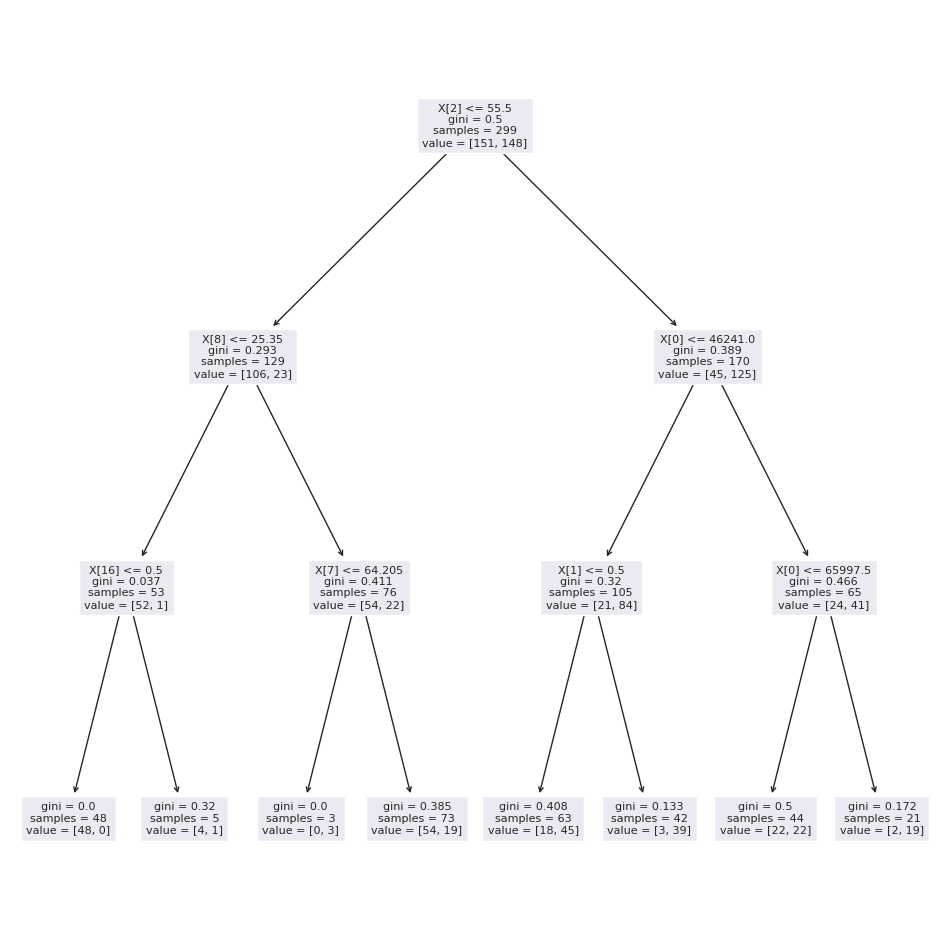

Accuracy score for decision tree model: 

 0.782608695652174 




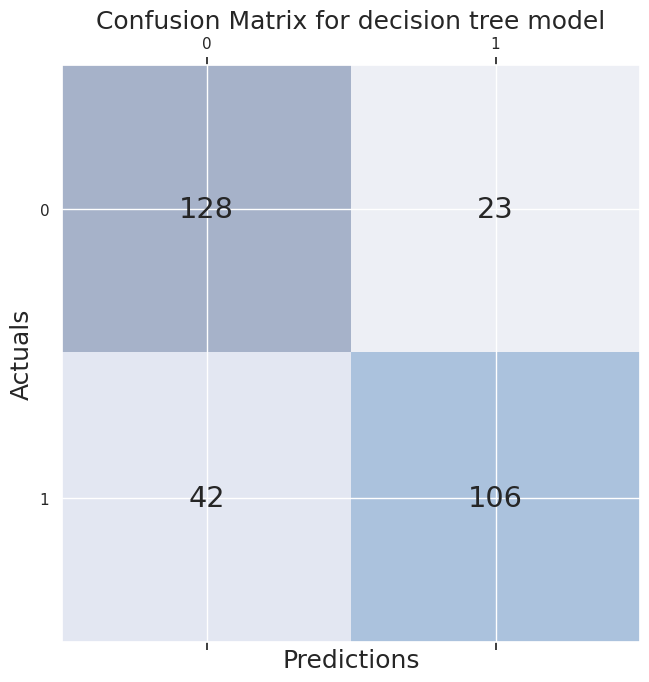

In [29]:
# run the model on balanced dataset

f.run_kmeans(X_train1, y_train1)

Using a balanced dataset decreased the accuracy of the model to 42%. Possbily as the dataset is now very small with only 499 records used in the analysis.

The decision tree model accuracy is also lower (78.3%) than when using all of the data. However, the classification of stroke patients is significantly better than in the previous model. Therefore, this model is more useful for predicting stroke cases.

- Adjusted rand score: value between -1 and 1 where 0 indicates random clusters and 1 indicates a perfect model.

# PCA

Explained variance ratios: 

 [9.99994301e-01 4.55877469e-06 1.02684362e-06 1.09338957e-07
 7.62696609e-10 6.31611245e-10 5.41458955e-10 5.09434016e-10
 4.22792644e-10 3.54385090e-10 3.05364592e-10 2.45841957e-10
 1.70863394e-10 1.19908160e-10 9.64908920e-11 1.28901845e-11
 3.54106360e-41 1.03246818e-41] 




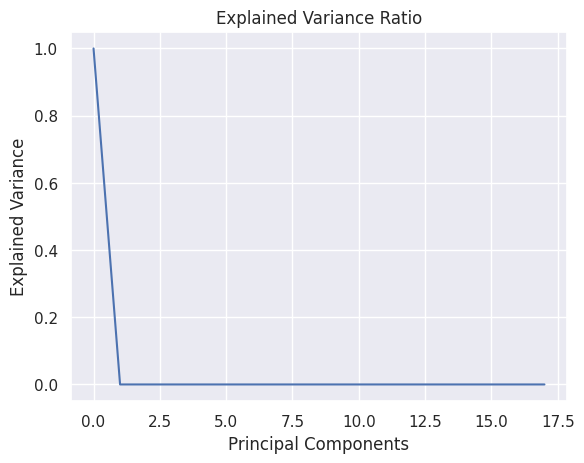

Explained variance ratio: 

 [9.99994301e-01 4.55877469e-06] 


Variance explained by the first 2 components: 

     99.9999% 


           PCA1        PCA2  stroke
0  -2928.226373  -28.154992       0
1 -24763.227106  -31.670108       0
2   4359.773527   10.431975       0
3  -9555.227074  107.702472       0
4   5436.772602  -43.160052       0


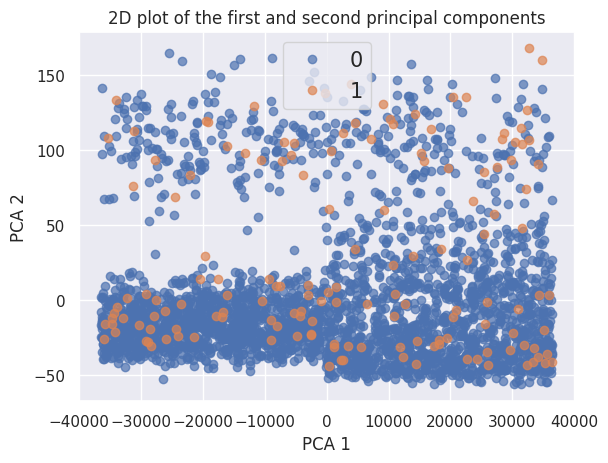

In [30]:
f.run_pca(feature_df = X_train, y_data = stroke_target, pca_components = 2)

99.99% of the variance is explained by the first 2 components. There are no clear clusters seen in the data, there are no obvious outliers but this may be due to the spread of the data.

# Tuning hyperparameters using validation set

In [47]:
# Use validate set to tune hyper parameters and then run model using best parameters

# Create a KMeans instance
kmeans = KMeans()

# Define the hyperparameter grid
param_grid = {'init': ['k-means++', 'random'],
              'max_iter': [100, 200, 300]}

# Perform a grid search over the hyperparameter grid
grid_search = GridSearchCV(kmeans, param_grid=param_grid)

# Fit the grid search to the stroke data
grid_search.fit(X_validate)

# Print the best parameters and best score
print("Best parameters: {}".format(grid_search.best_params_))


# ref 13

Best parameters: {'init': 'k-means++', 'max_iter': 200}


In [48]:
# Compare the 2 models on the TEST SET - using tuned hyper parameters
# 1) K-means

scaler = StandardScaler()

X_test_ss = scaler.fit_transform(X_test)

# run KMeans model

model = KMeans(n_clusters = 2, init = 'random', max_iter = 200, random_state = 0)
kmeans = model.fit(X_test_ss)

# check the accuracy of K-means model
predictions = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))
print(f'\n\n Inertia: {kmeans.inertia_}')

# The accuracy has improved with tuning of the hyperparmeters to 92.27% 

# inertia score = sum of squared distances between each point and it's assigned cluster centroid. (within cluster sum of squares)

Accuracy: 0.9227


 Inertia: 15880.38261636889


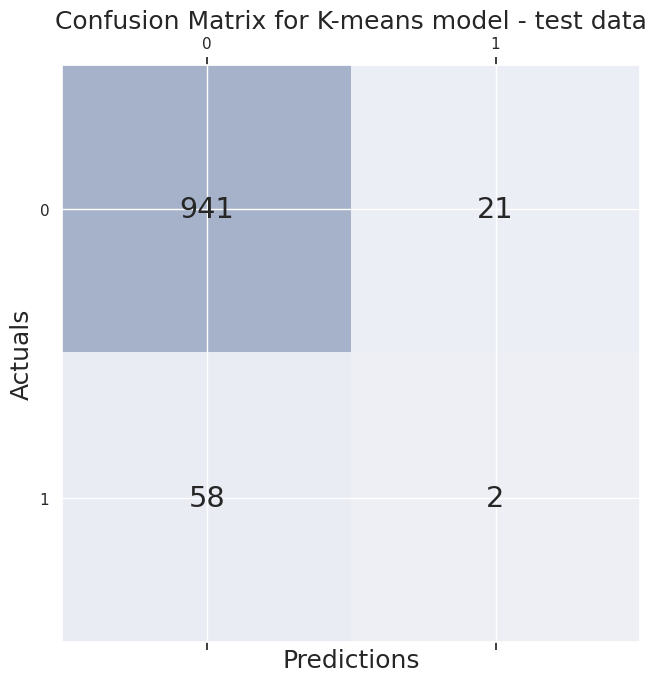

In [49]:
# Plot confusion matrix

conf_matrix=confusion_matrix(y_test, predictions) 

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', 
            ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for K-means model - test data', fontsize=18)
plt.show()

# shows this model hasn't really improved the prediction of stroke cases

Tuning decision tree hyperparameters

In [ ]:
# Tune the hyperparameters for decision tree model using the validate set

# Define the hyperparameters to tune
from sklearn.tree import DecisionTreeClassifier


params = {'max_depth': [4, 6, 8, 10],
          'min_samples_leaf': [1, 2, 4],
          'min_samples_split': [2, 4, 6, 8],
        'max_features': ['auto', 'sqrt']}

# Create a decision tree classifier object
dt = DecisionTreeClassifier()

# Create a grid search object
grid_search = GridSearchCV(estimator = dt, param_grid = params, cv = 5)

# Fit the grid search object to the data
grid_search.fit(X_validate, y_validate)

# Print the best hyperparameters
print(grid_search.best_params_)

# min_samples_leaf: Minimum number of data points in a leaf node
# max_depth: Max depth of the tree

# ref 14

{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}


In [43]:
# 2) Run model on test set using optimal hyperparameters - whole dataset

clf = tree.DecisionTreeClassifier(max_depth = 4, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 2, random_state = 0)
clf = clf.fit(X_test, y_test)

predictions_clf = clf.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, predictions_clf))

predictions_clf

# tuning the hyperparameters has led to a slightly lower (but similar) accuracy score then orginal decision tree model.

Accuracy: 0.9442


array([0, 0, 0, ..., 0, 0, 0])

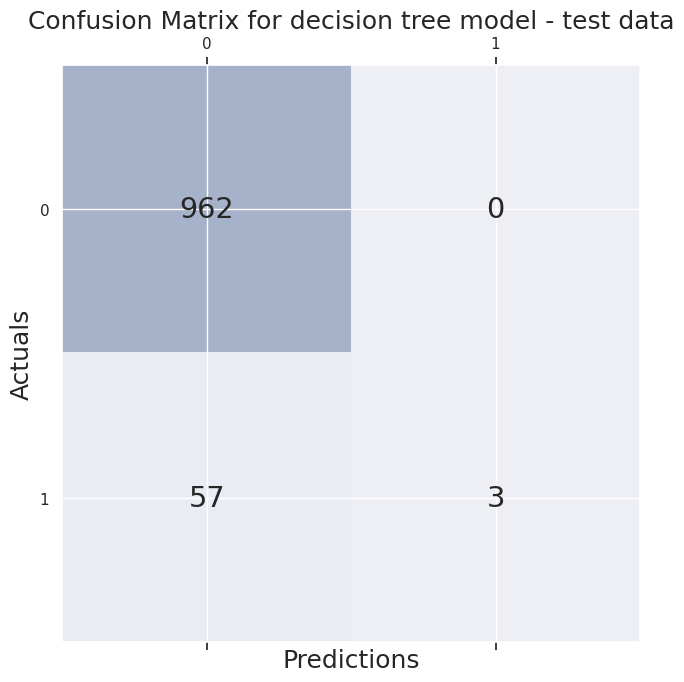

In [44]:
# Plot confusion matrix

conf_matrix=confusion_matrix(y_test, predictions_clf) 

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', 
            ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for decision tree model - test data', fontsize=18)
plt.show()

In [45]:
# 3) Run model on test set using optimal hyperparameters - balanced dataset

clf = tree.DecisionTreeClassifier(max_depth = 4, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 2, random_state = 0)
clf = clf.fit(X_test, y_test)

predictions_clf1 = clf.predict(X_test1)
print('Accuracy: %.4f' % accuracy_score(y_test1, predictions_clf1))

predictions_clf1

# tuning the hyperparameters has led to a slightly lower (but similar) accuracy score then orginal decision tree model.

Accuracy: 0.5300


array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

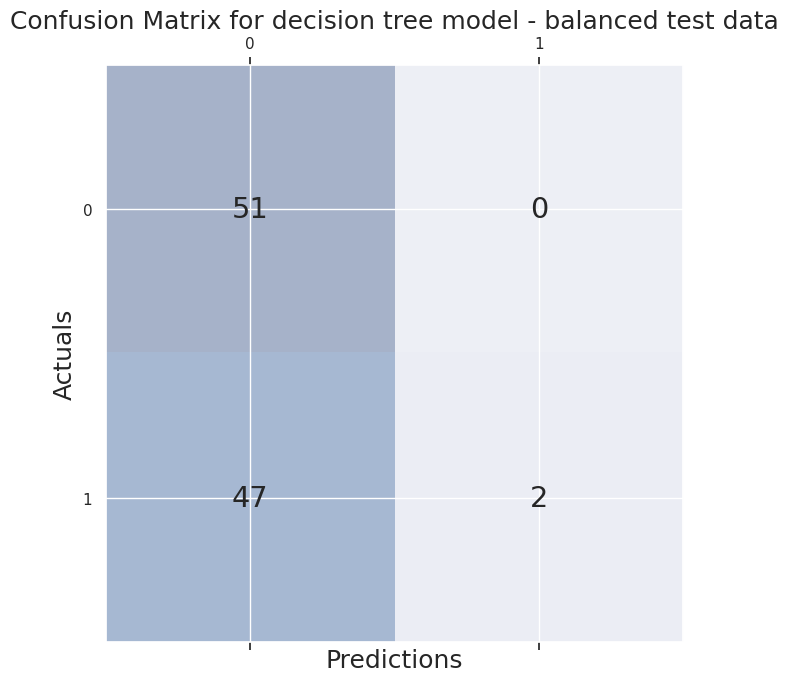

In [46]:
# Plot confusion matrix

conf_matrix=confusion_matrix(y_test1, predictions_clf1) 

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', 
            ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for decision tree model - balanced test data', fontsize=18)
plt.show()

# has largely reduced the correct classification of stroke cases.
 
# Why? 
# - hyperparameters optimised to overfit?
# - lack of well defined groups in dataset may mean optimising not enough to help
# - Interaction between hyperparameters = may be best values individually but not neccesarily best when combined

# Conclusions

- The best model for finding stoke cases was using a decision tree model on a balanced dataset without tuning the hyper-parameters.

- K-means method provided a model with reasonably high accuracy of 78.6%. However, the stroke cases were almost all mislabelled in correlation matrix. Therefore, the model is not much use in this case. 

- This could be due to the unbalanced nature of the data, the relatively low correlations between variables and the lack of clearly defined clusters.

- Creating a balanced dataset made the model accuracy worse with 42.2% accuracy achieved. Possibly due to the sample size becoming relatively small. However, runing decision tree model on balanced dataset had a reasonably accuracy of 78.3% and much better classification of the stroke cases.

- Tuning the hyper-parameters improved the accuracy of the k-means model to 89.8% accuracy. However, it did not improve the mislabelling of stroke cases.

- The first 2 principal component explain 99.99% of the variation in the dataset. The clusters show no separation.

- Using a decision tree resulted in a model with 95% classification accuracy for predicting whether or not a person is likely to have a stroke. However, it also still misclassified stroke cases.

- Tuning the decision tree hyper-parameters did not improve the model further, with accuracy of 94.4% achieved and mislabelling of stroke cases still occured.

- Considering that predicting whether a person is likely to have a stroke is a medical question, only models with very high accuracy at correctly classifying the stroke cases (1s) would be acceptable in a real world scenario. 

# The dataset

- https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv

# References

1) https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c
2) https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
3) https://predictivehacks.com/k-means-elbow-method-code-for-python/
4) https://www.naftaliharris.com/blog/visualizing-k-means-clustering/
5) https://scikit-learn.org/stable/modules/feature_selection.html
6) http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2015/tutorials/r5_pca.html
7) https://stackoverflow.com/questions/55678708/interpretation-of-pca-explained-variance-ratio
8) https://www.kaggle.com/code/anyfish/stroke-prediction-dataset
9) https://www.datatechnotes.com/2020/05/anomaly-detection-with-kmeans-in-python.html
10) https://scikit-learn.org/stable/modules/tree.html
11) https://stackoverflow.com/questions/59447378/sklearn-plot-tree-plot-is-too-small
12) https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html
13) https://scikit-learn.org/stable/modules/grid_search.html
14) https://towardsdatascience.com/hyperparameter-tuning-with-grid-search-and-random-search-6e1b5e175144
15) https://stackoverflow.com/questions/65683128/how-to-plot-the-cost-inertia-values-in-sklearn-kmeans

# Articles

a) https://link.springer.com/article/10.1007/s13748-016-0094-0